# Autoencoders


This code includes implementations of various simple autoencoders using the Keras front end to TensorFlow.
We'll run all of the code on the MNIST data to gain a basic understanding of what everything is doing. 
You'll then run this on the Fashion MNIST data.

The starter code for this demo is from [https://github.com/ardendertat/Applied-Deep-Learning-with-Keras](https://github.com/ardendertat/Applied-Deep-Learning-with-Keras). For Keras documentation, see [https://keras.io](https://keras.io).



In [1]:
from __future__ import print_function
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import warnings

warnings.filterwarnings('ignore')
from keras.models import Model
from keras.layers import Dense, Input
from keras.datasets import mnist
from keras.datasets import fashion_mnist
from keras.regularizers import l1
from keras.optimizers import Adam

## Utility functions



In [2]:
def plot_autoencoder_outputs(autoencoder, n, dims):
    decoded_imgs = autoencoder.predict(x_test)

    # number of example digits to show
    plt.figure(figsize=(2*n, 4.5))
    for i in range(n):
        # plot original image
        ax = plt.subplot(2, n, i + 1)
        plt.imshow(x_test[i].reshape(*dims))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        if i == n/2:
            ax.set_title('Original Images')

        # plot reconstruction 
        ax = plt.subplot(2, n, i + 1 + n)
        plt.imshow(decoded_imgs[i].reshape(*dims))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        if i == n/2:
            ax.set_title('Reconstructed Images')
    plt.show()


## Read the data


In [3]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))

print(x_train.shape)
print(x_test.shape)

11493376/11490434 [==============================] - 12s 1us/step
(60000, 784)
(10000, 784)


## Shallow autoencoder


In [10]:
input_size = 784
code_size = 32

input_img = Input(shape=(input_size,))
code = Dense(code_size, activation='relu')(input_img)
output_img = Dense(input_size, activation='sigmoid')(code)

autoencoder = Model(input_img, output_img)
# optimizer makes a huge difference. Adam maintains independent learning params for each
# sgd is really bad by comparison 
autoencoder.compile(optimizer='adam', loss='mean_squared_error')
autoencoder.fit(x_train, x_train, epochs=5)

Epoch 1/5
60000/60000 [==============================] - 3s 54us/step - loss: 0.0320
Epoch 2/5
60000/60000 [==============================] - 3s 49us/step - loss: 0.0135
Epoch 3/5
60000/60000 [==============================] - 3s 47us/step - loss: 0.0112
Epoch 4/5
60000/60000 [==============================] - 3s 50us/step - loss: 0.0107
Epoch 5/5
60000/60000 [==============================] - 3s 48us/step - loss: 0.0106


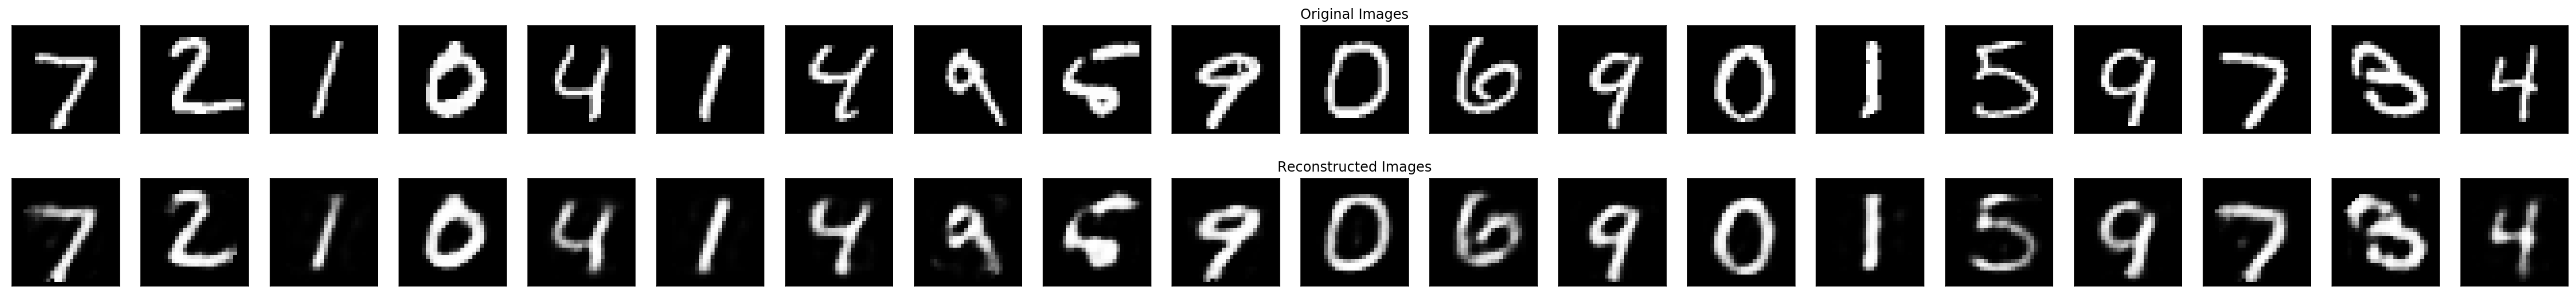

In [11]:
plot_autoencoder_outputs(autoencoder, 20, (28, 28))

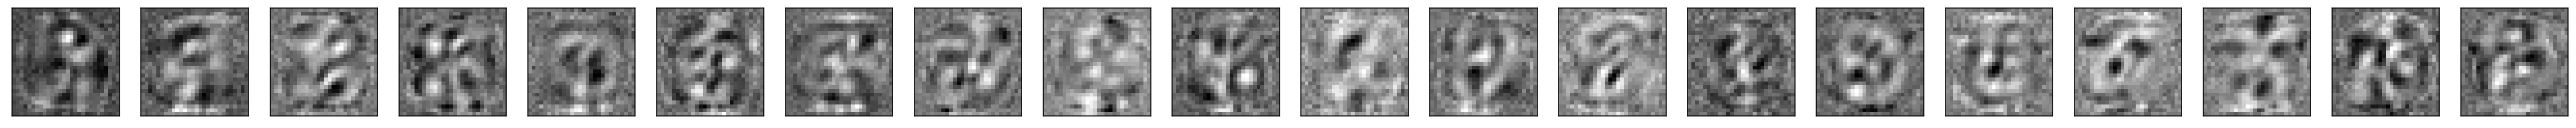

In [12]:
# the weights are just the shape of the data (784 numbers)
# you can reshape them into 28*28 image
# these patterns can be visualized
# they are not interpretable by humans but we can 
# reconstruct the data from this low dimensional projection 
weights = autoencoder.get_weights()[0].T

n = 20
plt.figure(figsize=(n*2, 5))
for i in range(n):
    ax = plt.subplot(1, n, i + 1)
    plt.imshow(weights[i+0].reshape(28, 28))
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

## 2-Layer Autoencoder


In [13]:
input_size = 784
hidden_size = 128
code_size = 32

input_img = Input(shape=(input_size,))
hidden_1 = Dense(hidden_size, activation='relu')(input_img)
code = Dense(code_size, activation='relu')(hidden_1)
hidden_2 = Dense(hidden_size, activation='relu')(code)
output_img = Dense(input_size, activation='sigmoid')(hidden_2)

autoencoder = Model(input_img, output_img)
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')
autoencoder.fit(x_train, x_train, epochs=10)

Epoch 1/10
60000/60000 [==============================] - 7s 114us/step - loss: 0.1381
Epoch 2/10
60000/60000 [==============================] - 6s 107us/step - loss: 0.1010
Epoch 3/10
60000/60000 [==============================] - 7s 109us/step - loss: 0.0954
Epoch 4/10
60000/60000 [==============================] - 7s 109us/step - loss: 0.0924
Epoch 5/10
60000/60000 [==============================] - 6s 108us/step - loss: 0.0905
Epoch 6/10
60000/60000 [==============================] - 6s 107us/step - loss: 0.0891
Epoch 7/10
60000/60000 [==============================] - 6s 108us/step - loss: 0.0880
Epoch 8/10
60000/60000 [==============================] - 7s 110us/step - loss: 0.0872
Epoch 9/10
60000/60000 [==============================] - 8s 136us/step - loss: 0.0865
Epoch 10/10
60000/60000 [==============================] - 10s 167us/step - loss: 0.0860


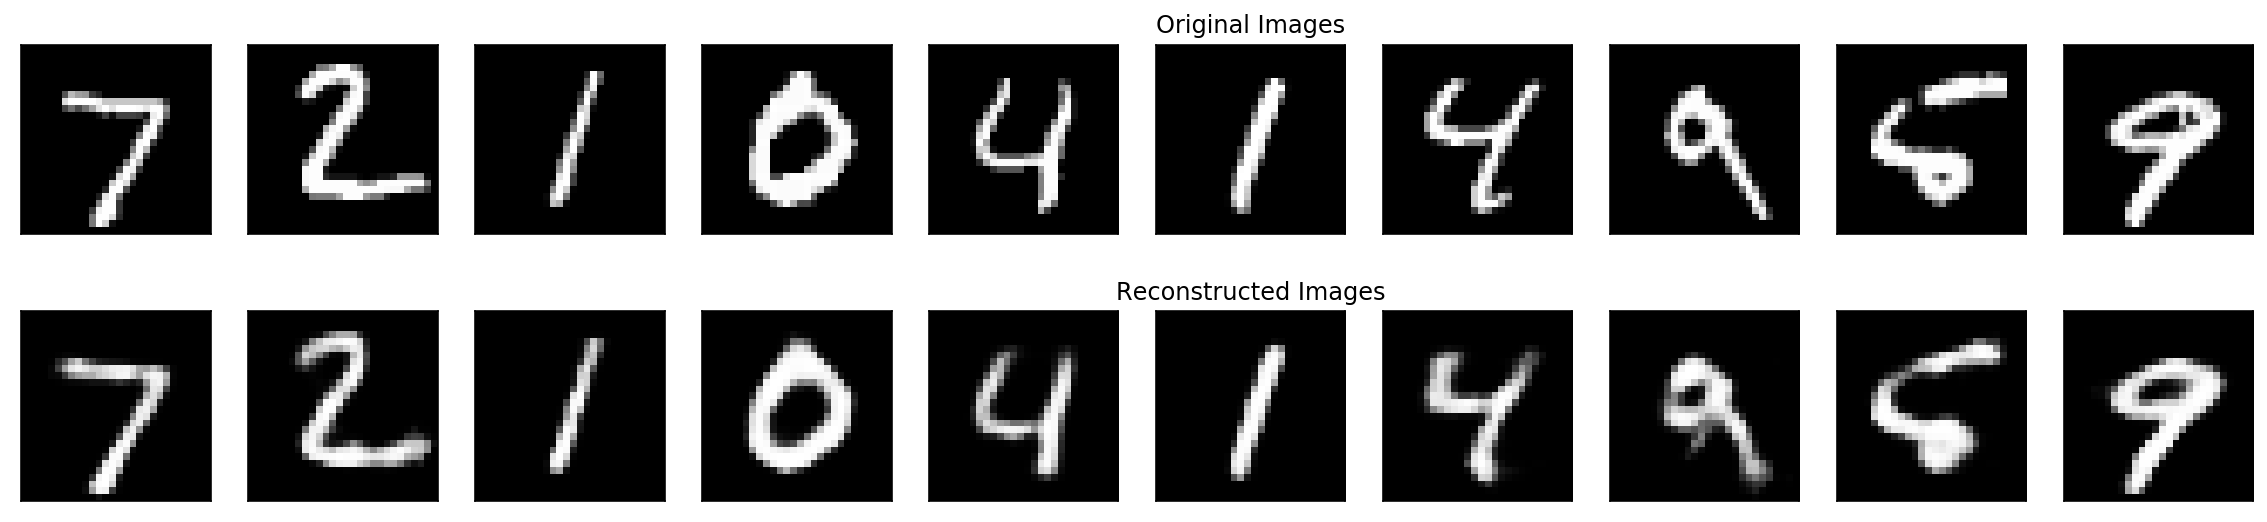

In [14]:
plot_autoencoder_outputs(autoencoder, 10, (28, 28))

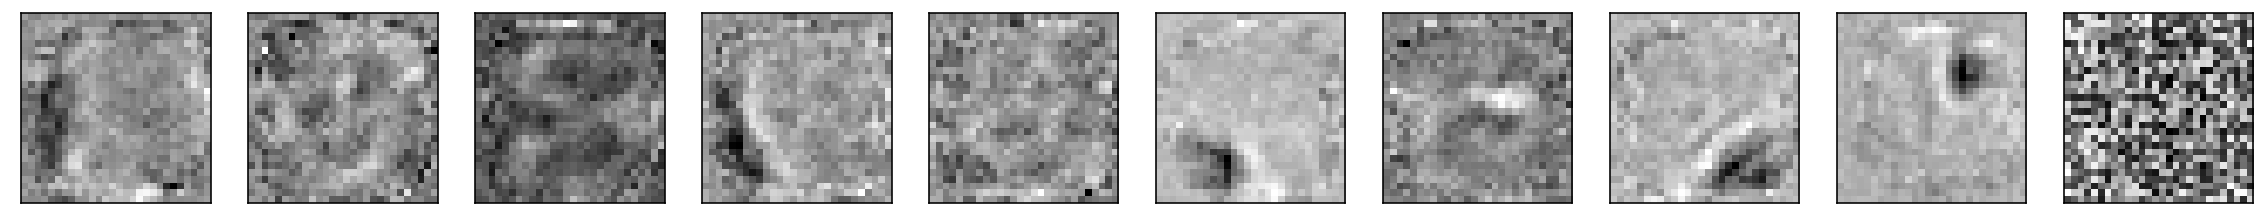

In [15]:
weights = autoencoder.get_weights()[0].T

n = 10
plt.figure(figsize=(20, 5))
for i in range(n):
    ax = plt.subplot(1, n, i + 1)
    plt.imshow(weights[i+0].reshape(28, 28))
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    

## Denoising autoencoder


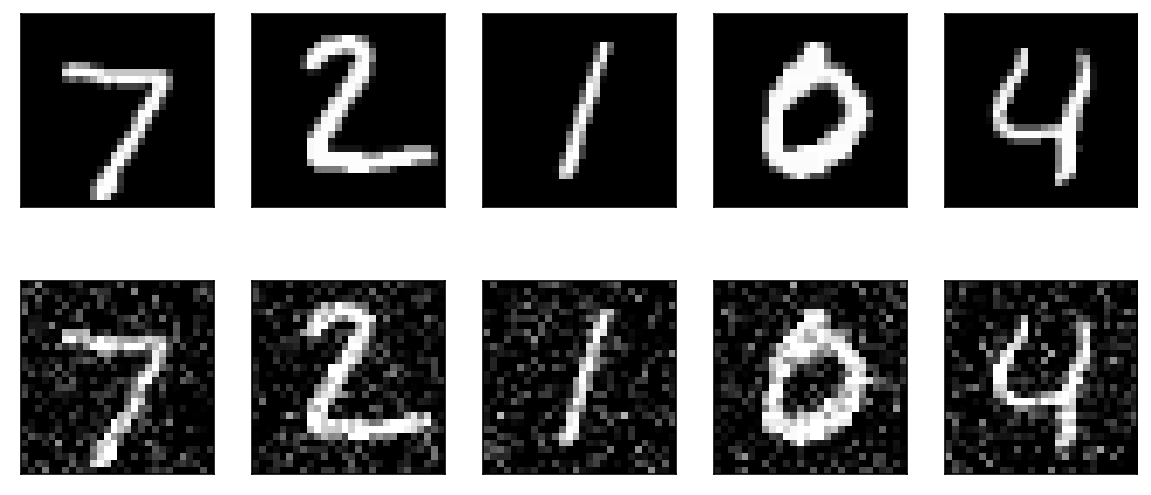

In [16]:
noise_factor = 0.20
x_train_noisy = x_train + noise_factor * np.random.normal(size=x_train.shape) 
x_test_noisy = x_test + noise_factor * np.random.normal(size=x_test.shape)

x_train_noisy = np.clip(x_train_noisy, 0.0, 1.0)
x_test_noisy = np.clip(x_test_noisy, 0.0, 1.0)

n = 5
plt.figure(figsize=(10, 4.5))
for i in range(n):
    # plot original image
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    if i == n/2:
        ax.set_title('Original Images')

    # plot noisy image 
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(x_test_noisy[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    if i == n/2:
        ax.set_title('Noisy Input')

In [17]:
input_size = 784
hidden_size = 128
code_size = 32

input_img = Input(shape=(input_size,))
hidden_1 = Dense(hidden_size, activation='relu')(input_img)
code = Dense(code_size, activation='relu')(hidden_1)
hidden_2 = Dense(hidden_size, activation='relu')(code)
output_img = Dense(input_size, activation='sigmoid')(hidden_2)

autoencoder = Model(input_img, output_img)
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')
autoencoder.fit(x_train_noisy, x_train, epochs=10)

Epoch 1/10
60000/60000 [==============================] - 7s 117us/step - loss: 0.1480
Epoch 2/10
60000/60000 [==============================] - 7s 123us/step - loss: 0.1124
Epoch 3/10
60000/60000 [==============================] - 7s 116us/step - loss: 0.1059
Epoch 4/10
60000/60000 [==============================] - 7s 115us/step - loss: 0.1027
Epoch 5/10
60000/60000 [==============================] - 7s 118us/step - loss: 0.1002 0s - 
Epoch 6/10
60000/60000 [==============================] - 7s 115us/step - loss: 0.0986
Epoch 7/10
60000/60000 [==============================] - 7s 113us/step - loss: 0.0975
Epoch 8/10
60000/60000 [==============================] - 7s 111us/step - loss: 0.0966
Epoch 9/10
60000/60000 [==============================] - 7s 110us/step - loss: 0.0960
Epoch 10/10
60000/60000 [==============================] - 7s 112us/step - loss: 0.0955


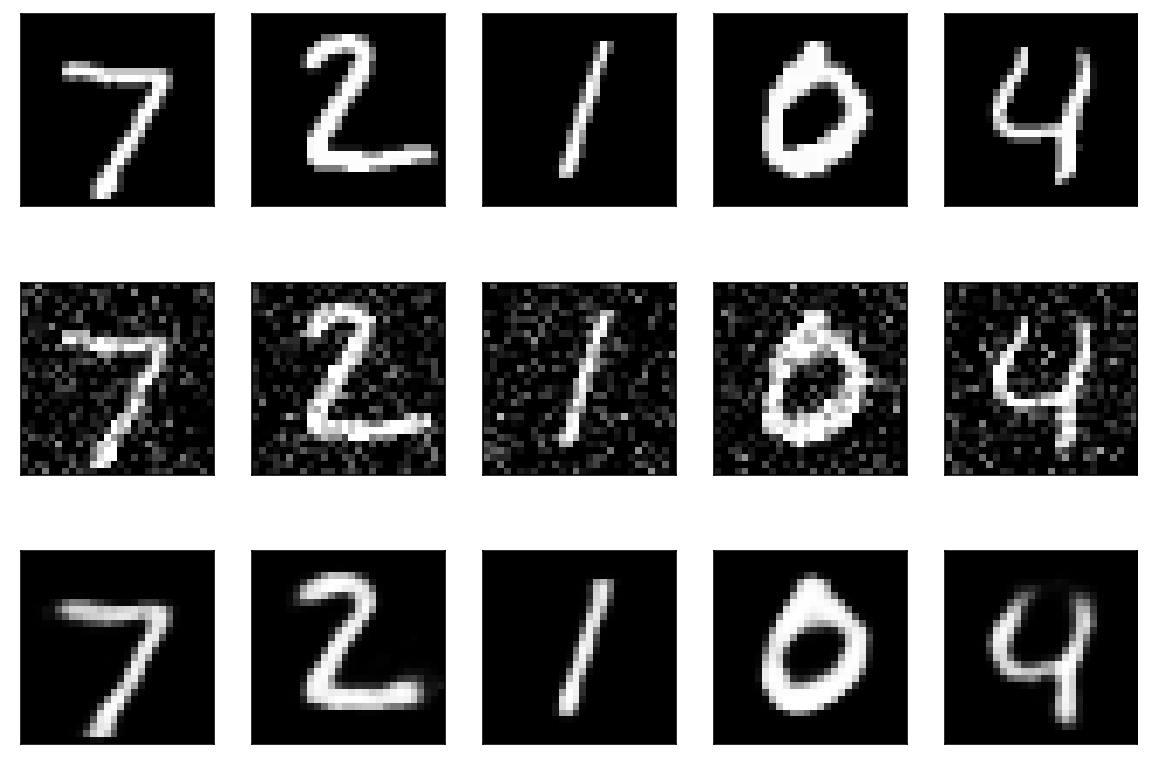

In [18]:
n = 5
plt.figure(figsize=(10, 7))

images = autoencoder.predict(x_test_noisy)

for i in range(n):
    # plot original image
    ax = plt.subplot(3, n, i + 1)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    if i == n/2:
        ax.set_title('Original Images')

    # plot noisy image 
    ax = plt.subplot(3, n, i + 1 + n)
    plt.imshow(x_test_noisy[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    if i == n/2:
        ax.set_title('Noisy Input')
        
    # plot noisy image 
    ax = plt.subplot(3, n, i + 1 + 2*n)
    plt.imshow(images[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    if i == n/2:
        ax.set_title('Autoencoder Output')

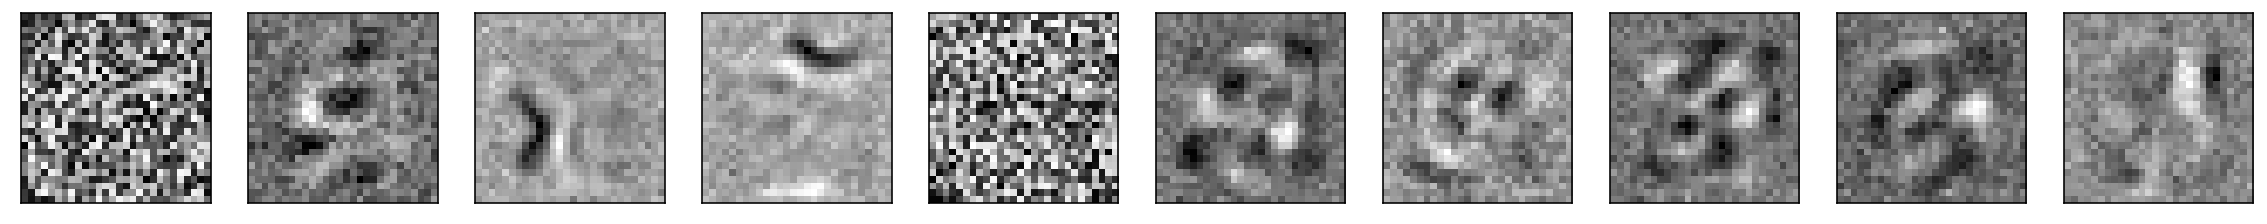

In [19]:
weights = autoencoder.get_weights()[0].T

n = 10
plt.figure(figsize=(20, 5))
for i in range(n):
    ax = plt.subplot(1, n, i + 1)
    plt.imshow(weights[i+0].reshape(28, 28))
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

# some of the weights are full of noise
# could it be because the net is under-trained? if you train more, 
# you might get patterns to emerge

## Sparse autoencoders


In [14]:
input_size = 784
hidden_size = 128
code_size = 32

input_img = Input(shape=(input_size,))
hidden_1 = Dense(hidden_size, activation='relu')(input_img)
code = Dense(code_size, activation='relu')(hidden_1)
hidden_2 = Dense(hidden_size, activation='relu')(code)
output_img = Dense(input_size, activation='sigmoid')(hidden_2)

autoencoder_standard = Model(input_img, output_img)
autoencoder_standard.compile(optimizer='adam', loss='binary_crossentropy')
history_standard = autoencoder_standard.fit(x_train, x_train, epochs=20)

encoded_standard = Model(input_img, code)

Epoch 1/20
60000/60000 [==============================] - 5s 87us/step - loss: 0.1373
Epoch 2/20
60000/60000 [==============================] - 5s 82us/step - loss: 0.0989
Epoch 3/20
60000/60000 [==============================] - 5s 81us/step - loss: 0.0934
Epoch 4/20
60000/60000 [==============================] - 5s 81us/step - loss: 0.0906
Epoch 5/20
60000/60000 [==============================] - 5s 82us/step - loss: 0.0888
Epoch 6/20
60000/60000 [==============================] - 5s 81us/step - loss: 0.0876
Epoch 7/20
60000/60000 [==============================] - 5s 81us/step - loss: 0.0866
Epoch 8/20
60000/60000 [==============================] - 5s 82us/step - loss: 0.0857
Epoch 9/20
60000/60000 [==============================] - 5s 81us/step - loss: 0.0850
Epoch 10/20
60000/60000 [==============================] - 5s 81us/step - loss: 0.0845
Epoch 11/20
60000/60000 [==============================] - 5s 82us/step - loss: 0.0840
Epoch 12/20
60000/60000 [===========================

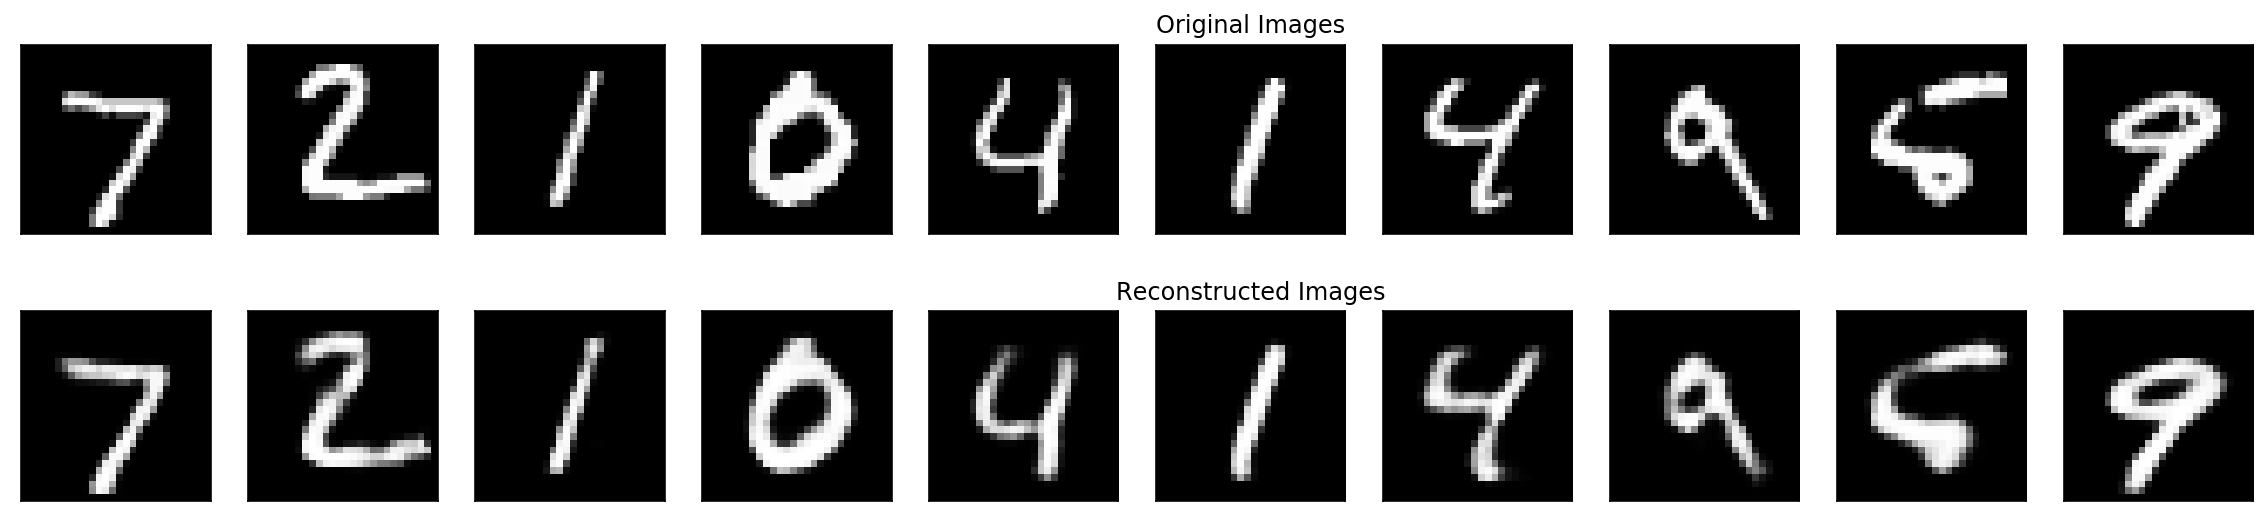

In [15]:
plot_autoencoder_outputs(autoencoder_standard, 10, (28, 28))

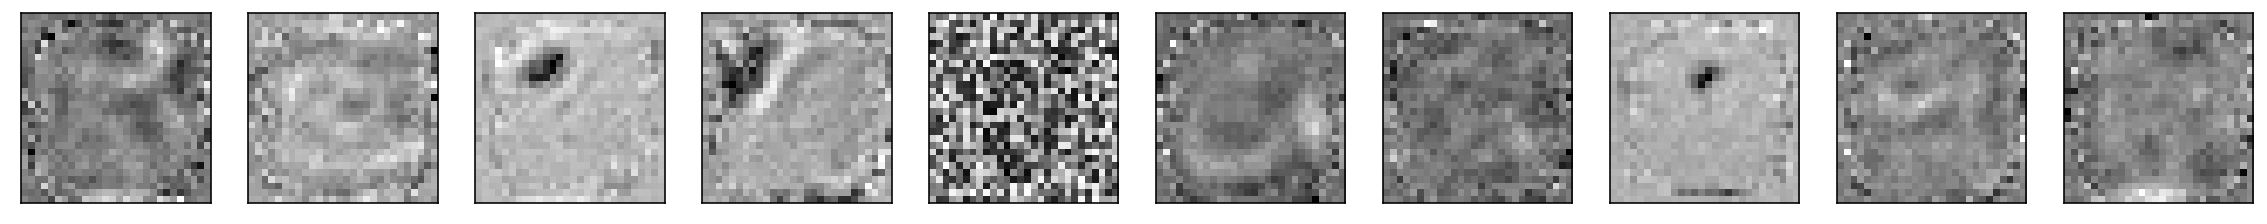

In [16]:
weights = autoencoder_standard.get_weights()[0].T

n = 10
plt.figure(figsize=(n*2, 5))
for i in range(n):
    ax = plt.subplot(1, n, i + 1)
    plt.imshow(weights[i].reshape(28, 28))
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

In [17]:
input_size = 784
hidden_size = 128
code_size = 32


input_img = Input(shape=(input_size,))
hidden_1 = Dense(hidden_size, activation='relu', activity_regularizer=l1(10e-6))(input_img)
code = Dense(code_size, activation='relu', activity_regularizer=l1(10e-6))(hidden_1)
hidden_2 = Dense(hidden_size, activation='relu')(code)
output_img = Dense(input_size, activation='sigmoid')(hidden_2)

autoencoder_regularized = Model(input_img, output_img)
autoencoder_regularized.compile(optimizer='adam', loss='binary_crossentropy')
history_regularized = autoencoder_regularized.fit(x_train, x_train, epochs=20)

encoded_regularized = Model(input_img, code)

Epoch 1/20
60000/60000 [==============================] - 6s 105us/step - loss: 0.1703
Epoch 2/20
60000/60000 [==============================] - 6s 94us/step - loss: 0.1272
Epoch 3/20
60000/60000 [==============================] - 6s 95us/step - loss: 0.1162
Epoch 4/20
60000/60000 [==============================] - 6s 93us/step - loss: 0.1100
Epoch 5/20
60000/60000 [==============================] - 6s 92us/step - loss: 0.1066
Epoch 6/20
60000/60000 [==============================] - 6s 95us/step - loss: 0.1042
Epoch 7/20
60000/60000 [==============================] - 5s 92us/step - loss: 0.1025
Epoch 8/20
60000/60000 [==============================] - 6s 92us/step - loss: 0.1011
Epoch 9/20
60000/60000 [==============================] - 6s 95us/step - loss: 0.0999
Epoch 10/20
60000/60000 [==============================] - 6s 96us/step - loss: 0.0989
Epoch 11/20
60000/60000 [==============================] - 6s 103us/step - loss: 0.0979
Epoch 12/20
60000/60000 [=========================

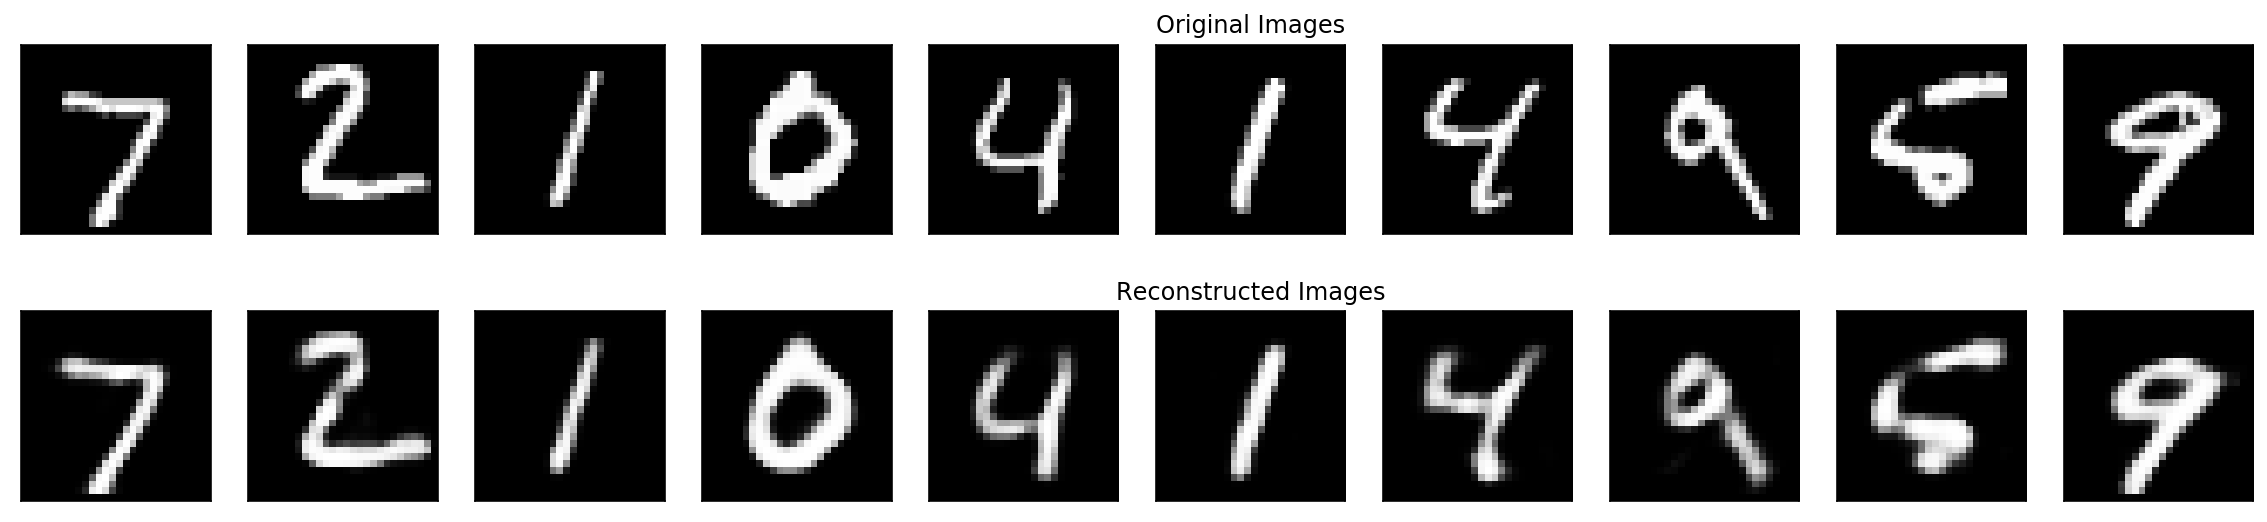

In [18]:
plot_autoencoder_outputs(autoencoder_regularized, 10, (28, 28))

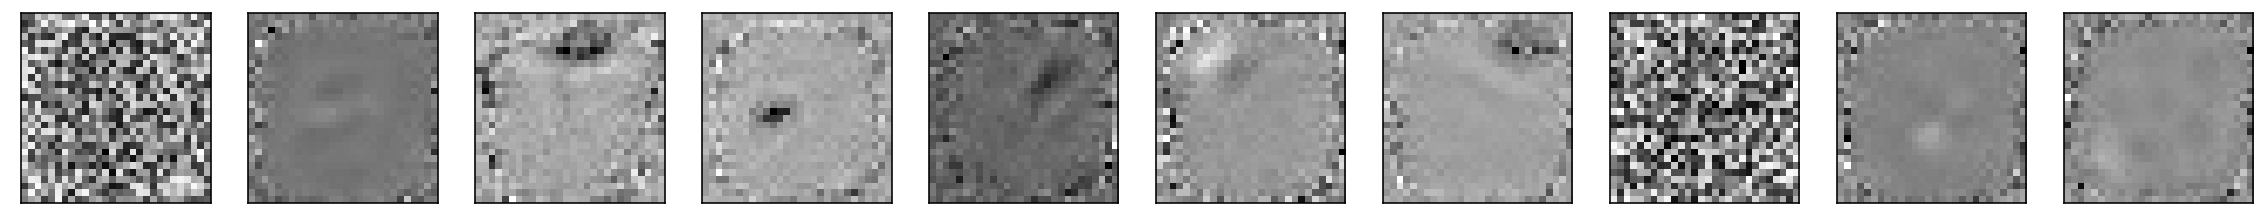

In [19]:
weights = autoencoder_regularized.get_weights()[0].T

n = 10
plt.figure(figsize=(2*n, 5))
for i in range(n):
    ax = plt.subplot(1, n, i + 1)
    plt.imshow(weights[i].reshape(28, 28))
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)